# Ucitavanje podataka

U ovoj svesci bavićemo se, takođe, zadatkom klasifikacije MNIST slika. U pristupu ćemo koristiti konvolutivne neuronske mreže.



In [1]:
import sys
sys.path.append('..')  

import matftorch

In [ ]:
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
data_dir = '/files/'
norm_mean = 0
norm_stddev = 1
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((norm_mean,), (norm_stddev,))
])

valid_size = 0.2
shuffle = True
num_workers = 8
pin_memory = False
RANDOM_STATE = 1389
BATCH_SIZE_TRAIN = 2048
BATCH_SIZE_TEST = 1000

In [ ]:
train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
valid_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=train_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
  np.random.seed(RANDOM_STATE)
  np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, sampler=train_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE_TRAIN, sampler=valid_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, sampler=None,
                                           num_workers=num_workers, pin_memory=pin_memory)

100%|██████████| 9912422/9912422 [00:00<00:00, 104178889.56it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114603305.42it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32197636.80it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20011059.63it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Dizajn Konvolutivnog modela


Naš model će se sastojati iz više konvolutivnih i agregacionih slojeva.

Konvolutivni slojevi se na nivou biblioteke kreiraju korišćenjem funkcije `Conv2D`.  Prvo se navodi broj filtera (parametar `filters`, obično neimenovan), zatim veličine kernela (`kernel_size` parametar), veličina pomeraja (parametar `strides`) i uokvirenje (`padding` parametar). <img src='assets/convolution_operation.gif' style='height: 300px'>

Na primer, na slici je prikazan kernel veličine 3x3 (kvadratić sive boje) koji prolazi kroz ulaz (kvadratić plave boje) sa horizontalnim i vertikalnim pomerajem veličine 2. Dodati beli skup kvadrata predstavlja uokvirenje i u zavisnosti od njegovog prisustva veličina izlazne slike (kvadratić zelene boje) može biti istih dimenzija (u Keras biblioteci se ovo naglašava vrednošću `same` parametra `padding`) ili nešto manja (u Keras biblioteci se ovo naglašava vrednošću `valid` parametra `padding`).

Agregacioni slojevi (`MaxPooling2D` i `AvgPooling2D`) vrše redukciju slojeva svođenjem blokova zadatih večina na njihove maksimalne ili prosečne vrednosti. Veličina bloka zadaje se parametrom `pool_size`. <img src='assets/pooling.png' style='width: 300px'>

Prilikom treniranja koristićemo i `Dropout` tehniku regularizacije. Podsetimo se da na ovaj način isključujemo nasumično odabrane neurone, omogućavamo drugačiji protok podataka kroz mrežu i smanjujemo zavisnosti izlaza od ulaza. <img src='assets/dropout.png'> Da bi se primenila ova tehnika regularizacije, dovoljno je mreži dodati `Dropout` sloj. Njegov parametar je verovatnoća isključivanja pojedinačnih neurona.

Sloj ispravljanja, sloj `Flatten`, se korist za transformisanje matrica vrednosti u vektore i obično se koristi kao priprema za prelazak sa konvolutivnog dela na dalji gusti deo mreže.

In [ ]:
import torch.nn.functional as F

In [ ]:
class MNISTConvClassifier(nn.Module):
    def __init__(self, number_of_classes):
        super(MNISTConvClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(input=x, kernel_size=2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

# Trening Modela

In [ ]:
%%time

number_of_classes = 10
model = MNISTConvClassifier(number_of_classes)
matftorch.bind_gpu(model)
model

CPU times: user 68 ms, sys: 233 ms, total: 301 ms
Wall time: 482 ms


MNISTConvClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
matftorch.count_parameters(model)

Layer: conv1, Parameters: 320
Layer: conv2, Parameters: 18496
Layer: dropout1, Parameters: 0
Layer: dropout2, Parameters: 0
Layer: fc1, Parameters: 1179776
Layer: fc2, Parameters: 1290


1199882

In [ ]:
N_EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_losses, train_accuracies, val_losses, val_accuracies = matftorch.train_classification(model, criterion, optimizer, N_EPOCHS, train_loader, valid_loader, True)

Epoch [1/30], Train Loss: 1.1370, Train Accuracy: 0.6398
Epoch [1/30], Validation Loss: 0.3741, Validation Accuracy: 0.8888
Epoch [2/30], Train Loss: 0.4224, Train Accuracy: 0.8715
Epoch [2/30], Validation Loss: 0.2534, Validation Accuracy: 0.9272
Epoch [3/30], Train Loss: 0.3080, Train Accuracy: 0.9083
Epoch [3/30], Validation Loss: 0.1875, Validation Accuracy: 0.9428
Epoch [4/30], Train Loss: 0.2332, Train Accuracy: 0.9307
Epoch [4/30], Validation Loss: 0.1409, Validation Accuracy: 0.9567
Epoch [5/30], Train Loss: 0.1786, Train Accuracy: 0.9474
Epoch [5/30], Validation Loss: 0.1060, Validation Accuracy: 0.9684
Epoch [6/30], Train Loss: 0.1430, Train Accuracy: 0.9584
Epoch [6/30], Validation Loss: 0.0866, Validation Accuracy: 0.9726
Epoch [7/30], Train Loss: 0.1199, Train Accuracy: 0.9651
Epoch [7/30], Validation Loss: 0.0721, Validation Accuracy: 0.9786
Epoch [8/30], Train Loss: 0.1015, Train Accuracy: 0.9699
Epoch [8/30], Validation Loss: 0.0638, Validation Accuracy: 0.9806
Epoch [9

# Evaluacija modela

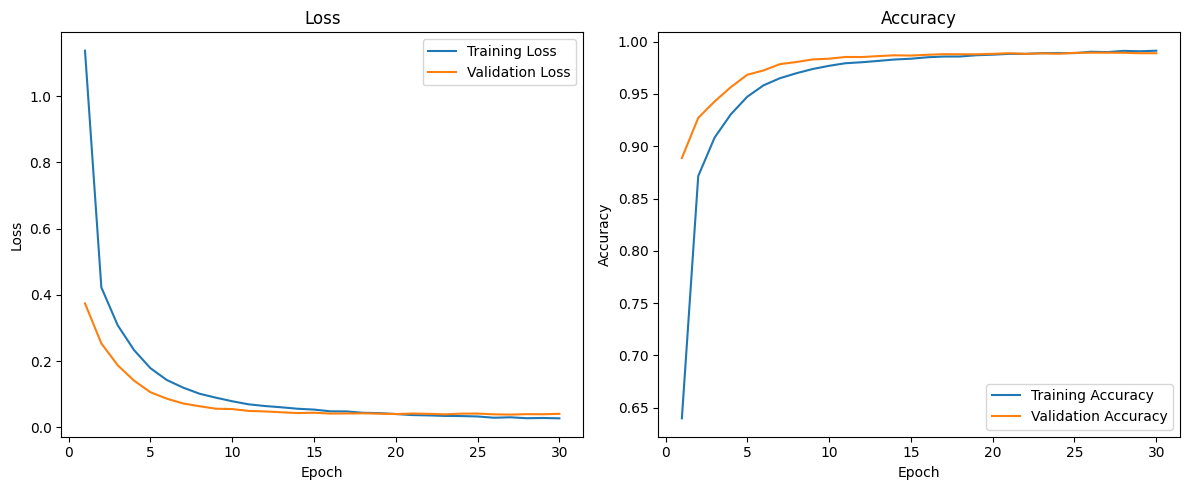

In [ ]:
matftorch.plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7e3f07892fe0>
Accuracy: 0.9985
Precision: 0.9985
Recall: 0.9985
F1 Score: 0.9985
Train Set: Loss: 0.0057, Accuracy: 0.9985


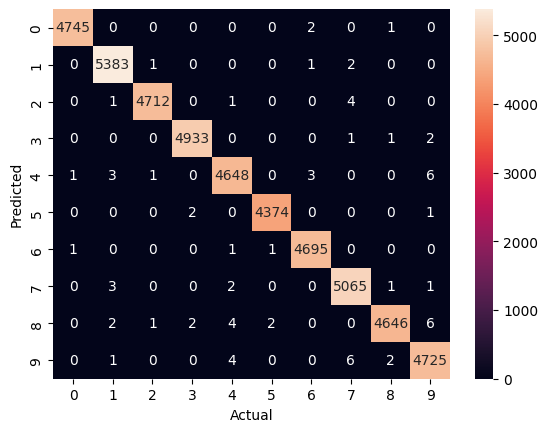

In [ ]:
train_loss, train_accuracy = matftorch.evaluate_classification(model, criterion, train_loader, True)
print(f'Train Set: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7e3f07891720>
Accuracy: 0.9908
Precision: 0.9908
Recall: 0.9908
F1 Score: 0.9908
Train Set: Loss: 0.0300, Accuracy: 0.9908


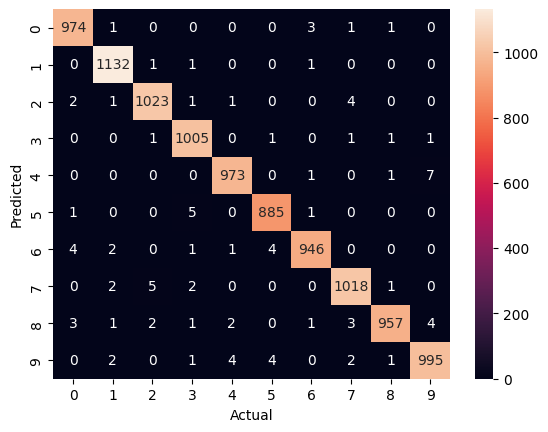

In [ ]:
test_loss, test_accuracy = matftorch.evaluate_classification(model, criterion, test_loader, True)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')